# Split into Train / Valid / Test set

## 1.  Load Dataset from sklearn

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from IPython.display import Image

In [3]:
from sklearn.datasets import fetch_california_housing
california = fetch_california_housing()

In [4]:
df = pd.DataFrame(california.data, columns=california.feature_names)
df["Target"] = california.target
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24,0.894


## 2. Convert to PyTorch Tensor( 데이터 불러왔으면 텐서로 바꿔야해)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [6]:
data = torch.from_numpy(df.values).float() #numpy값인 df의 값들(values)을 정수꼴로 가져온다

x = data[:, :-1]
y = data[:, -1:]

print(x.size(), y.size())

torch.Size([20640, 8]) torch.Size([20640, 1])


In [6]:
# Train / Valid / Test ratio
ratios = [.6, .2, .2]

In [7]:
train_cnt = int(data.size(0) * ratios[0]) # int 꼭 붙여줘야해!!!!!!
valid_cnt = int(data.size(0) * ratios[1])
test_cnt = data.size(0) - train_cnt - valid_cnt
cnts = [train_cnt, valid_cnt, test_cnt]

print("Train %d / Valid %d / Test %d samples." % (train_cnt, valid_cnt, test_cnt))

Train 12384 / Valid 4128 / Test 4128 samples.


In [8]:
# 3. 셔플링
indices = torch.randperm(data.size(0)) #x.size(0)만큼 셔플링해
x = torch.index_select(x, dim=0, index=indices) # x랑 y 같이 셔플링해!!
y = torch.index_select(y, dim=0, index=indices)

# Split train, valid and test set with each count.
x = list(x.split(cnts, dim=0)) #x를 train, valid, test 사이즈로 나눈 값을 리스트로 저장한다. 전처리에서 각 사이즈별로 정규분포로 만듦
y = y.split(cnts, dim=0)#똑같은사이즈의 y랑 split한 x와 대조하기위해 각각의 똑같은 사이즈로 split해준다

for x_i, y_i in zip(x, y): #결과를 찍어보면 training set을 12384
    print(x_i.size(), y_i.size())

torch.Size([12384, 8]) torch.Size([12384, 1])
torch.Size([4128, 8]) torch.Size([4128, 1])
torch.Size([4128, 8]) torch.Size([4128, 1])


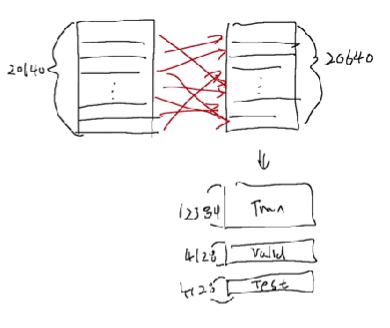

In [3]:
Image("C:\\Users\\ryusu\\OneDrive\\바탕 화면\\40.png")

## Preprocessing - loss구하기전에 데이터부터 전처리해야함

In [9]:
scaler = StandardScaler()
# StandardScaler = 기존 변수의 범위를 정규 분포로 변환하는 것
scaler.fit(x[0].numpy()) # Train data(x[0])만 바꿔야한다
# 아까 데이터 전체를 텐서로 바꿔줌. .numpy() 시용해서 텐서에서 numpy 배열로 변환가능

#x[0]은 train set의 입력. 그럼 scaler는 뮤와 시그마를 컬럼별로 가지고 있게됨.
#train set 인 x만 정규분포로 만들어준다!!!! - 중요!!
# 아까 구해놓은 평균과 표준편차를 적용해서 transform 함

x[0] = torch.from_numpy(scaler.transform(x[0].numpy())).float() #x[0] = train set 
#x[0]라는 numpy (x[0].numpy()값에서)tesor로 변환하는데(torch.from_numpy) float()(정수값)을 가짐 
x[1] = torch.from_numpy(scaler.transform(x[1].numpy())).float() #x[1] = valid set
x[2] = torch.from_numpy(scaler.transform(x[2].numpy())).float() #x[2] = test set

df = pd.DataFrame(x[0].numpy(), columns=california.feature_names) #정규화된 x[0]값 dataframe으로 만들고보기
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
12379,-1.337976,0.039268,0.938162,1.744210,-0.922676,-0.098696,-0.679357,1.758942
12380,0.181147,-2.096748,0.318691,0.063251,0.269824,-0.064301,0.553543,-0.145924
12381,0.116286,1.858838,-0.457874,0.380912,-0.949235,-0.076714,0.994198,-1.307793
12382,-0.021677,-0.593625,0.138888,-0.036659,-0.033834,-0.040006,-1.195020,1.245327
12383,-0.142738,1.225944,1.232146,0.992239,-0.648233,-0.240747,0.422282,-1.163182


## Build Model & Optimizer

In [10]:
model = nn.Sequential( #train set 값 x[0]값만 들어가야돼
    nn.Linear(x[0].size(-1), 6),
    nn.LeakyReLU(),
    nn.Linear(6, 5),
    nn.LeakyReLU(),
    nn.Linear(5, 4),
    nn.LeakyReLU(),
    nn.Linear(4, 3),
    nn.LeakyReLU(),
    nn.Linear(3, y[0].size(-1)),
)

model

Sequential(
  (0): Linear(in_features=8, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
)

In [11]:
optimizer = optim.Adam(model.parameters())#adam을 활용해서 learning rate 튜닝없이 아담을 적용할수있음

## Train

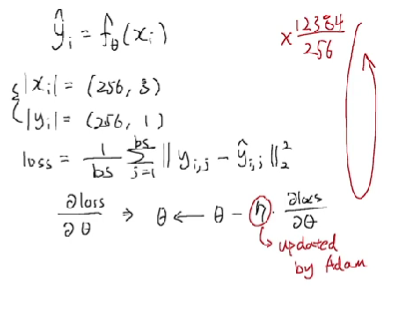

In [4]:
Image("C:\\Users\\ryusu\\OneDrive\\바탕 화면\\41.png")

In [12]:
n_epochs = 4000
batch_size = 256
print_interval = 100

In [13]:
from copy import deepcopy

lowest_loss = np.inf #numpy.inf: (양의) 무한대의 IEEE 754 부동소수점 표현
best_model = None 

early_stop = 100 #100 에폭epoch동안 validation loss 에 갱신이 없으면(validation loss 가 낮아지지않으면) 학습을 종료 

lowest_epoch = np.inf

In [7]:
train_history, valid_history = [], []

#x,y 각각 epoch를 만들고 mini-batch도 생성한다 

for i in range(n_epochs): #한 epoch당 minibatch로 나누는 과정 수행
    #한 epoch안에는 2개의 procedure로 나뉘어져있음. training iteration과 validation iteration
    
    indices = torch.randperm(x[0].size(0)) #x[0]은 training set의 사진갯수. size(0)
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
    # |x_| = (total_size, input_dim)
    # |y_| = (total_size, output_dim)
    
    x_ = x_.split(batch_size, dim=0)#미니배치 사이즈로 랜덤 split을 해줌
    y_ = y_.split(batch_size, dim=0)
    # |x_[i]| = (batch_size, input_dim)
    # |y_[i]| = (batch_size, output_dim)
    
    train_loss, valid_loss = 0, 0
    y_hat = []
    
    #이제 계산해준다
    for x_i, y_i in zip(x_, y_): #미니배치당 feed-forward 하고 backpropagation 하기
        # 그래서 우리는 12384/256 회의 iteration 을 돌거고 한 epoch안에는 그만큼의 파라미터 업데이트가 있음
        # |x_i| = |x_[i]|
        # |y_i| = |y_[i]|
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)

        optimizer.zero_grad()
        # Pytorch에서는 학습하고자 하는 가중치의 gradients값들을 추후에 backward를 해줄때 계속 더해주기 때문"에 우리는 항상 backpropagation을 하기전에 
        # gradients를 zero로 만들어주고 시작을 해야합니다.
        loss.backward()

        optimizer.step()        
        train_loss += float(loss)

    train_loss = train_loss / len(x_)

#Train 과정 끝나면 valid과정 해야지!!!   

    #validation set
    with torch.no_grad():
        #validation set은 학습을 하지 않기때문에 gradient descent(파라미터 업데이트)를 안할거니깐 이 과정을 안한다 라는뜻
        #속도가 빨라짐. 메모리도 절약

       #셔플링 필요없고 미니배치사이즈에 맞게 split
        # x[1]은 위에서 x를 scaler값 취해준 validation set값
        x_ = x[1].split(batch_size, dim=0)#귀찮아서 training set의 미니배치와 똑같은 사이즈로 가져간다
        y_ = y[1].split(batch_size, dim=0)
        
        valid_loss = 0
        
        for x_i, y_i in zip(x_, y_): #validation set은 셔플링 할 필요없음
            y_hat_i = model(x_i)
            loss = F.mse_loss(y_hat_i, y_i)
            
            valid_loss += loss #loss만 구하고 backpropagation은 하지않는다
            
            y_hat += [y_hat_i]
            
    valid_loss = valid_loss / len(x_) #그래서 평균 validation loss을 구하게된다
    
    # Log each loss to plot after training is done.
    train_history += [train_loss]
    valid_history += [valid_loss]
        
    if (i + 1) % print_interval == 0:
        print('Epoch %d: train loss=%.4e  valid_loss=%.4e  lowest_loss=%.4e' % (
            i + 1,
            train_loss,
            valid_loss,
            lowest_loss,
        ))
        
    if valid_loss <= lowest_loss: #현재 validation loss가 lowest loss보다 낮으면 
        lowest_loss = valid_loss #갱신을 하고
        lowest_epoch = i
        
        # 'state_dict()' returns model weights as key-value.
        # Take a deep copy, if the valid loss is lowest ever.
        best_model = deepcopy(model.state_dict()) 
        #깊은 복사(deep copy): 깊은 복사는 내부에 객체들까지 모두 새롭게 copy 되는 것
        #모델을 카피를 한다. 단순 카피하는게 아니라 state_dict(model의 weight 파라미터값을 dictionary 형태로 카피)
        
    else: #만약 갱신이 안된다면
        if early_stop > 0 and lowest_epoch + early_stop < i + 1: #맨마지막 갱신했던 epoch으로부터 100epcoh 이상이 지나면 break 를 건다.
        # Early stopping 은 무조건 Epoch 을 많이 돌린 후, 특정 시점에서 멈추는 것이다.


            print("There is no improvement during last %d epochs." % early_stop)
            break

print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))




#학습이 다 끝나면
# Load best epoch's model.

model.load_state_dict(best_model)

#모델중에서 best model를 불러온다

NameError: name 'n_epochs' is not defined

결과를 보면 539번째 epcoh에서 가장 낮았고 그후로 100번동안 639번째에서 종료되었다.

## Loss History

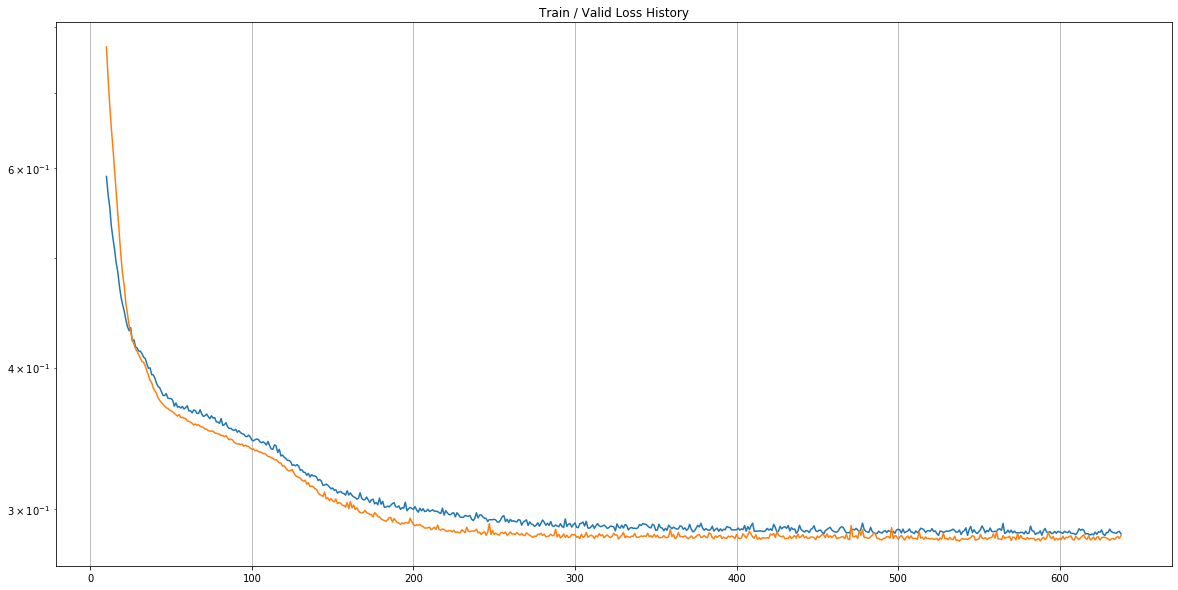

In [15]:
plot_from = 10

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()

## Let's see the result! - Test

In [16]:
test_loss = 0
y_hat = []

with torch.no_grad():
    x_ = x[2].split(batch_size, dim=0)
    y_ = y[2].split(batch_size, dim=0) #split 한후

    for x_i, y_i in zip(x_, y_): #feed-forward해서 loss를 찍어보고
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)

        test_loss += loss # Gradient is already detached.

        y_hat += [y_hat_i]

test_loss = test_loss / len(x_) #평균 loss를 구한다
y_hat = torch.cat(y_hat, dim=0)

sorted_history = sorted(zip(train_history, valid_history),
                        key=lambda x: x[1])

print("Train loss: %.4e" % sorted_history[0][0])
print("Valid loss: %.4e" % sorted_history[0][1])
print("Test loss: %.4e" % test_loss)

Train loss: 2.8728e-01
Valid loss: 2.8090e-01
Test loss: 2.9679e-01


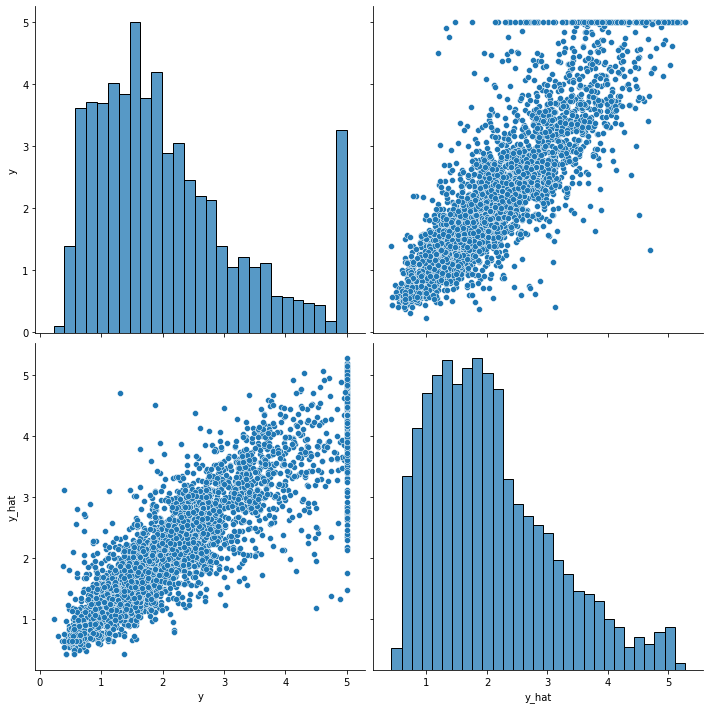

In [17]:
df = pd.DataFrame(torch.cat([y[2], y_hat], dim=1).detach().numpy(),
                  columns=["y", "y_hat"])

sns.pairplot(df, height=5)
plt.show()